Entropic Regularization of Optimal Transport
============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.

In [28]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helpers

In [29]:
"""To compute distance matrix"""
def distmat(x,y):
    
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum(a)

"""To Compute P"""
def GetP(u,K,v):
    return u*K*(v.T)

Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $a,b \in \Si_n$, where we denote the simplex in $\mathbb{R}^n$
$$ \Si_n := \enscond{ a \in \mathbb{R}_+^n }{ \sum_i a_i = 1 }.  $$
We consider the following discrete regularized transport
$$  W_\epsilon(a,b) := \min{P \in U(a,b)} \dotp{C}{P} - \epsilon E(P).  $$
where the polytope of coupling is defined as
$$ U(a,b) := \enscond{P \in (\mathbb{R}^+)^{n \times m}}{ P 1_m = a, P^\top 1_n = b },  $$
where $1_n := (1,\ldots,1)^\top \in \mathbb{R}^n $,
and for $P \in \mathbb{R}_+^{n \times m}$, we define its entropy as
$$ E(P) := -\sum_{i,j} P_{i,j} ( \log(P_{i,j}) - 1). $$


When $\epsilon=0$ one recovers the classical (discrete) optimal transport.
We refer to the monograph [Villani](#biblio) for more details about OT.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).


Here the matrix $C \in (\mathbb{R}^+)^{n \times m} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\epsilon(a,b) = \epsilon \min_{P \in U(a,b)} \textrm{KL}(P||Q)
	\textrm{ where }
	K_{i,j} := e^{ -\frac{C_{i,j}}{\epsilon} }  $$
of the Gibbs kernel $K$ according to the Kullback-Leibler divergence.
The Kullback-Leibler divergence between $P, K \in \mathbb{R}_+^{n \times m}$ is
$$ \textrm{KL}(P||Q) := \sum_{i,j} P_{i,j} \pa{ \log\pa{ \frac{P_{i,j}}{K_{i,j}} } - 1}. $$


This interpretation of regularized transport as a KL projection and its numerical
applications are detailed in [BenamouEtAl](#biblio).


Given a convex set $\Cc \subset \mathbb{R}^N$, the projection according to the Kullback-Leiber divergence is defined as
$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

# I. Introduction to Sinkhorn's Algorithm
-----------------------------------------------------------------------

A fundamental remark is that the optimality condition of the entropic regularized problem shows that the optimal coupling $P_\epsilon$ necessarily has the form 
$$P_\epsilon = \Delta{u} K \Delta{v}$$
where the Gibbs kernel is defined as
$$K := e^{-\frac{C}{\epsilon}}.$$

One thus needs to find two positive scaling vectors $u \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^m$ such that the two following equality holds
$$P 1  = u \odot (K v) = a 
\quad
P^\top 1  = v \odot (K^\top u) = b.$$

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$u \longleftarrow \frac{a}{K v} \quad v \longleftarrow \frac{b}{K^\top u}.$$
This algorithm was shown to converge to a solution of the entropic regularized problem by [Sinkhorn](#biblio).

Transport Between Point Clouds
------------------------------
We first test the method for two input measures that are uniform measures
(i.e. constant histograms) supported on two point clouds
(that do not necessarily have the same size).


We thus first load two points clouds $x=(x_i)_{i=1}^{n}, y=(y_i)_{i=1}^{m}, $
where $x_i, y_i \in \mathbb{R}^2$.


Number of points in each cloud, $N=(n,m)$.

In [30]:
X = np.random.rand(100)
Y = np.random.rand(100)
s = np.argsort(X)
print("Indices de tri: \n", s)
print("Echantillon trié:\n", X[s])

Indices de tri: 
 [13 56 76 90 84  9 97 98 93 24 20 19 23  0 65 94  2 12 11 39 43 95 89  4
  8 10 66 96 68 87 81  5 57 29 63 99 33 86 71 61 55  7 16 22  6 37 77 35
 47 85  1 42  3 91 34 67 48 26 27 14 72 74 44 17 45 88 64 49 59 78 21 31
 50 46 36 28 70 69 92 80 18 15 32 79 30 40 60 75 73 82 41 62 83 52 38 51
 25 54 58 53]
Echantillon trié:
 [0.0171613  0.05019774 0.05760735 0.0631439  0.07179761 0.10298247
 0.10671682 0.12744347 0.13931148 0.14636604 0.17759155 0.18675589
 0.18969754 0.23240255 0.2362024  0.24666235 0.2485593  0.25465719
 0.26139748 0.26383874 0.26842782 0.27160961 0.27281817 0.28266234
 0.2847718  0.28929719 0.29001107 0.29650041 0.29998458 0.30361813
 0.30852492 0.31741431 0.31840987 0.32378228 0.32900322 0.33273897
 0.33409269 0.3375261  0.35051222 0.36362364 0.39583013 0.39815437
 0.40691014 0.41323222 0.41732156 0.44125437 0.4516217  0.46018337
 0.47107076 0.47892737 0.49734096 0.51618085 0.51998374 0.5267839
 0.5439256  0.61332874 0.61551164 0.6171475  0.6423941 

In [31]:
N = [400,400]

Dimension of the clouds.

In [32]:
d = 2

Point cloud $x$, of $n$ points inside a square.

In [33]:
x = np.random.rand(2,N[0])-.5

Point cloud $y$, of $m$ points inside an anulus.

In [34]:
theta = 2*np.pi*np.random.rand(1,N[1])
r = .8 + .2*np.random.rand(1,N[1])
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

Shortcut for displaying point clouds.

In [35]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=200, edgecolors="k", c=col, linewidths=2)

Display of the two clouds.

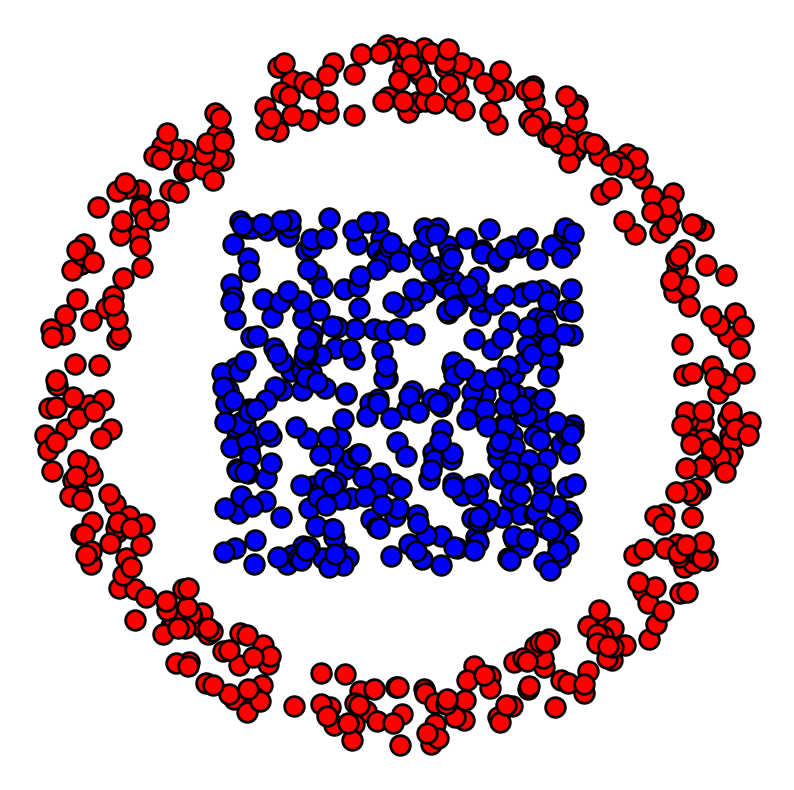

In [36]:
plt.figure(figsize=(10,10))

plotp(x, 'b')
plotp(y, 'r')

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [37]:

C = distmat(x,y)

Target histograms $(a,b)$, here uniform histograms.

In [38]:
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

In [39]:
import computational_OT

Gibbs Kernel $K$.

Initialization of $v=1_{m}$ ($u$ does not need to be
initialized).

Regularization strength $\epsilon>0$.

__Exercise 1__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$$ \norm{ P 1 - a }_1 \quad \norm{ P^\top 1 - b } $$
(you need to think about how to compute these residuals from $(u,v)$ alone).
isplay the violation of constraint error in log-plot.

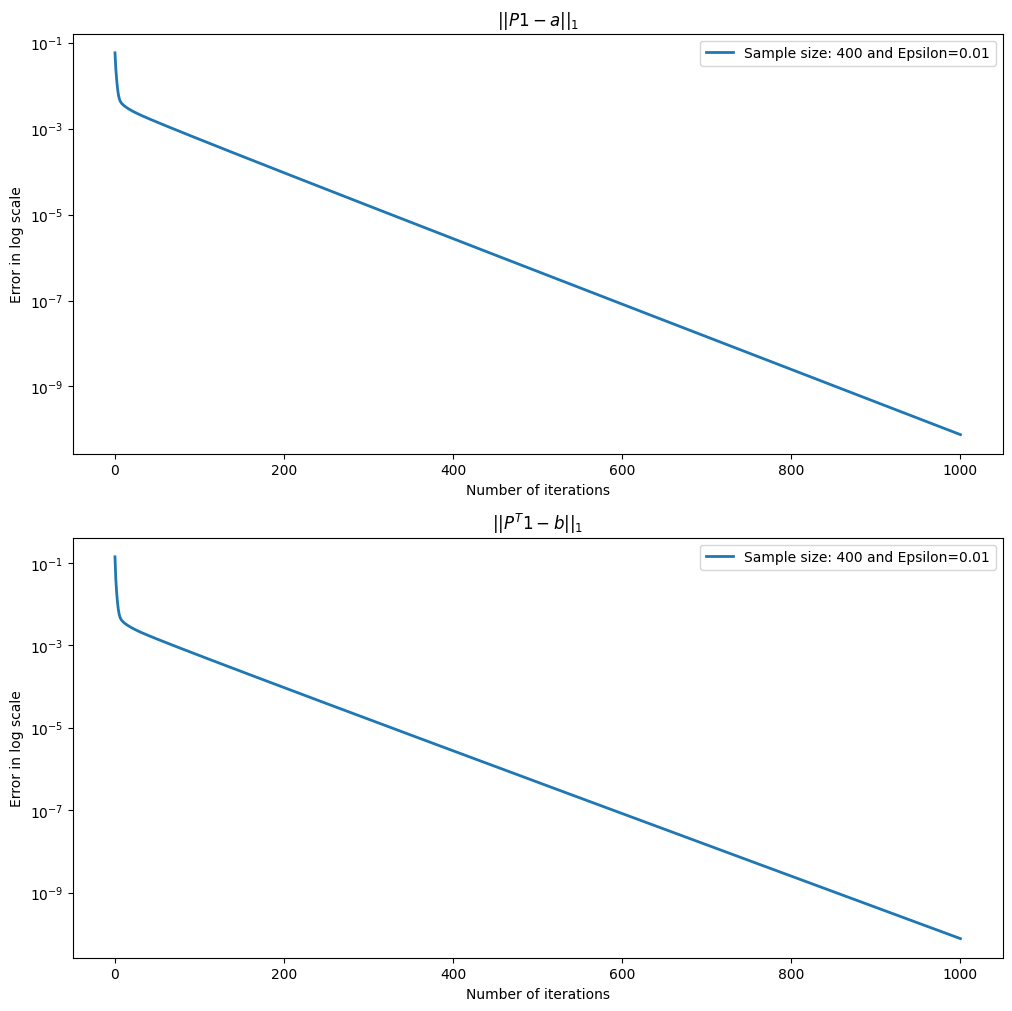

In [40]:
epsilon = .01
K = np.exp(-C/epsilon)
u=np.ones(N[0])
v = np.ones(N[1])



SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
out=SOptimizer._update(maxiter=1000)
#
# Plot
plt.figure(figsize = (12,12))

plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")
plt.plot( np.asarray(out[2]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")

plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot( np.asarray(out[3]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")
plt.show()

# II. Second order iteration: The Newton-Raphson scheme

Sinkhorn...
Newton-Raphson...

Spectral statistics:
Mean eigenvalue:  0.050003125000000065
List of smallest eigenvalues:  [0.00219447 0.0025     0.00250584 0.00706828 0.00877557 0.01423166
 0.01559926 0.02161027 0.02345936 0.02854986]
List of largest  eigenvalues:  [0.07145014 0.07654064 0.07838973 0.08440074 0.08576834 0.09122443
 0.09293172 0.09749416 0.09780553 0.1       ]
Condition number:  45.56913711383375


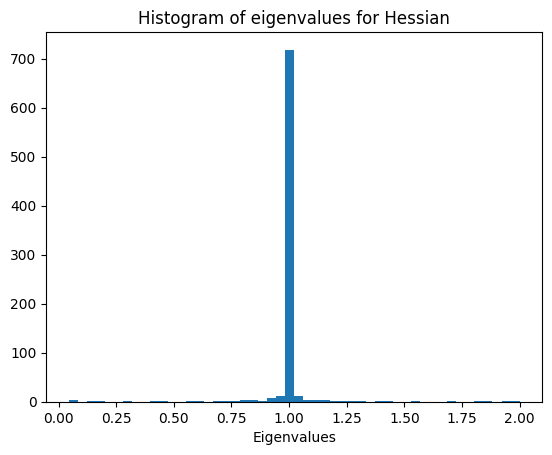

In [41]:
epsilon = 0.05
K = np.exp(-C/epsilon)
u=np.ones(N[0])
v = np.ones(N[1])


print("Sinkhorn...")
SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
outS=SOptimizer._update(maxiter=50)

print("Newton-Raphson...")
X = np.hstack( (outS[0],outS[1]) )
X = epsilon*np.log(X)
NOptimizer=computational_OT.NewtonRaphson(X,K,a,b,epsilon)
outN=NOptimizer._update(maxiter=10, debug=False)
print("")

# Spectral statistics
print( "Spectral statistics:")
hessian = NOptimizer._func_jacobian()
def print_spectral_statistics(mat):
    eig, v = np.linalg.eig( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    print( "Mean eigenvalue: ", np.mean(eig) )
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])
    min_index = np.argmin(np.abs(eig))
    max_index = np.argmax(np.abs(eig))
    min_value = eig[ min_index ]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    #print( "Min eigenvalue vector: ", max_vector)
    #
    #print( v[:,0]*np.sqrt( self.N1 + self.N2))
    #vector = v[:,0]
    #test = np.dot( result, vector)
    #print( np.linalg.norm(test) )
    #print("Min absolute eigenvalues: ", min_value)
    #print("Norm of v-1: ", np.linalg.norm(min_vector-eig_vector))
    print("Condition number: ", condition_number)
    plt.hist( eig/np.mean(eig), 50)
    plt.title( "Histogram of eigenvalues for Hessian")
    plt.xlabel( "Eigenvalues")
    plt.show()
# end def
print_spectral_statistics( hessian )


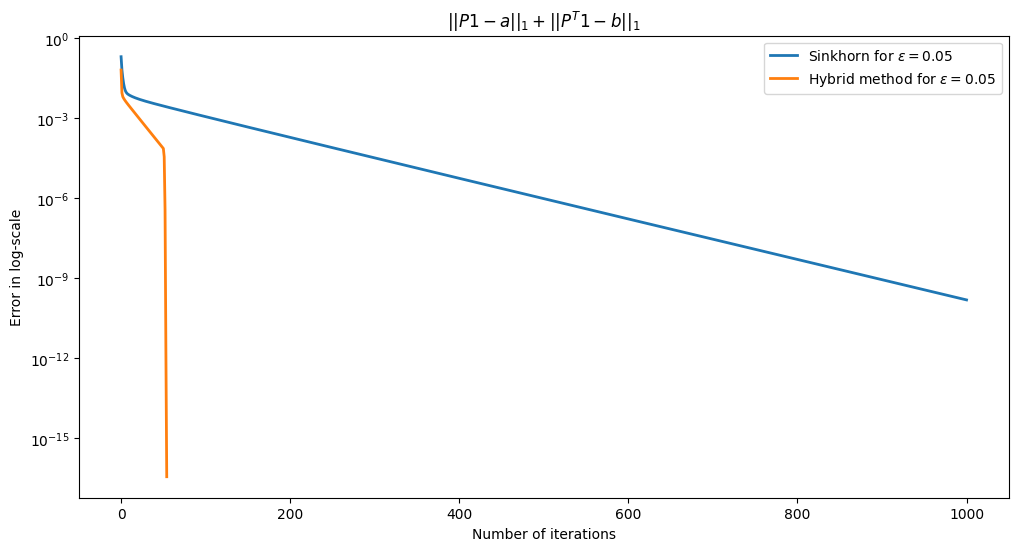

In [42]:
# Plot
plt.figure(figsize = (12,6))

#plt.subplot(2,1,1),
plt.title("$||P1 -a||_1 + ||P^T 1 -b||_1$")
error_sinkhorn = np.asarray(out[2]) + np.asarray(out[3])
error_hybrid   = np.asarray(outS[2]+outN[0]) + np.asarray(outS[3]+outN[1])
plt.plot( error_sinkhorn, label='Sinkhorn for $\epsilon=$' + str(epsilon), linewidth = 2)
plt.plot( error_hybrid,label='Hybrid method for $\epsilon=$'+ str(epsilon), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')

# plt.subplot(2,1,2)
# plt.title("$||P^T 1 -b||_1$")
# plt.plot( np.asarray(out[3]), label='Sinkhorn for $\epsilon=$' + str(epsilon), linewidth = 2)
# plt.plot( np.asarray(outS[3]+outN[1]),label='Hybrid method for $\epsilon=$'+ str(epsilon), linewidth = 2)
# plt.xlabel("Number of iterations")
# plt.ylabel("Error in log-scale")
# plt.legend()
# plt.yscale( 'log')

plt.show()


## III. Explore the sparsity of the matrices involved

Compute the final matrix $P$.

In [43]:
P = np.dot(np.dot(np.diag(outS[0]),K),np.diag(outS[1]))
Q1 = np.sort(P, axis=0)
Q2 = np.sort(P, axis=1)

Plot histogram

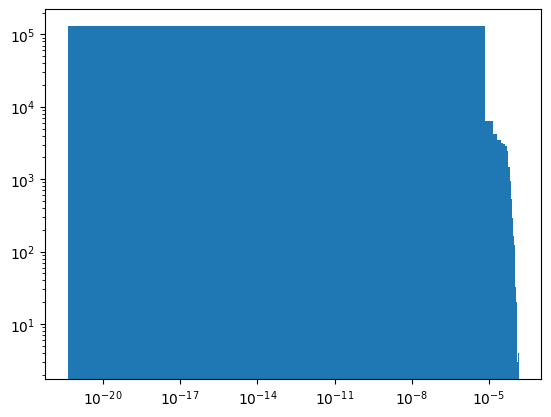

In [44]:
plt.hist( P.flatten(), 20)
plt.xscale( 'log')
plt.yscale( 'log')
plt.show()

Display it.

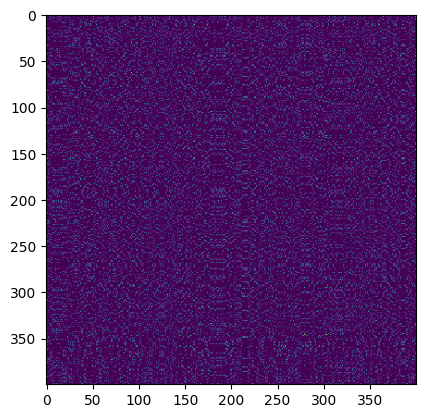

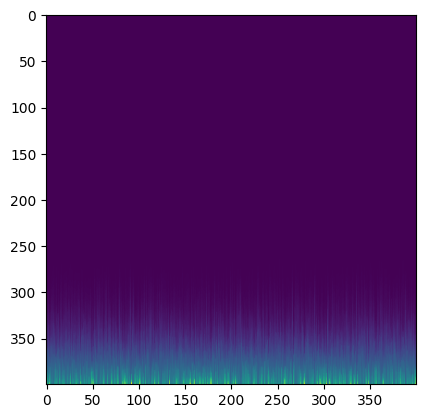

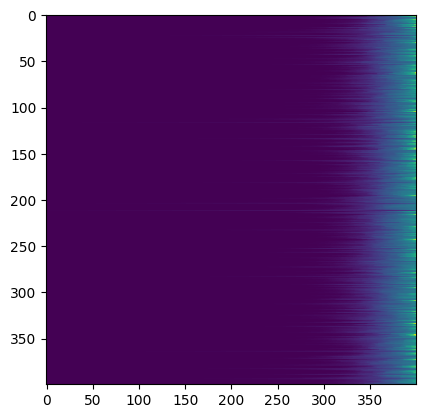

In [45]:
plt.figure()
plt.imshow(P);
plt.figure()
plt.imshow(Q1);
plt.figure()
plt.imshow(Q2);

In [56]:
Q1.shape

(400, 400)

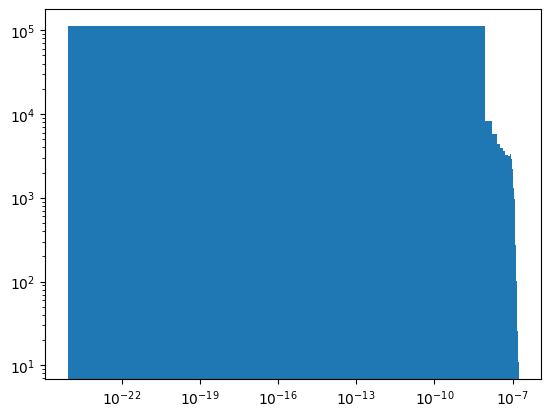

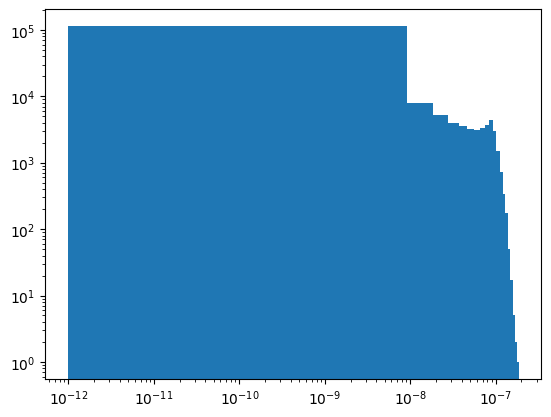

In [46]:
P_xx = np.dot(P, P.T)
P_yy = np.dot(P.T, P)
# plt.figure()
# plt.imshow( P_xx );
# plt.figure()
# plt.imshow( P_yy );
# plt.show()

plt.figure()
plt.hist( P_xx.flatten(), 20, cumulative=False)
plt.xscale( 'log')
plt.yscale( 'log')
plt.show()
plt.hist( P_yy.flatten(), 20, cumulative=False)
plt.xscale( 'log')
plt.yscale( 'log')
plt.show()

Cuthill-Mckee

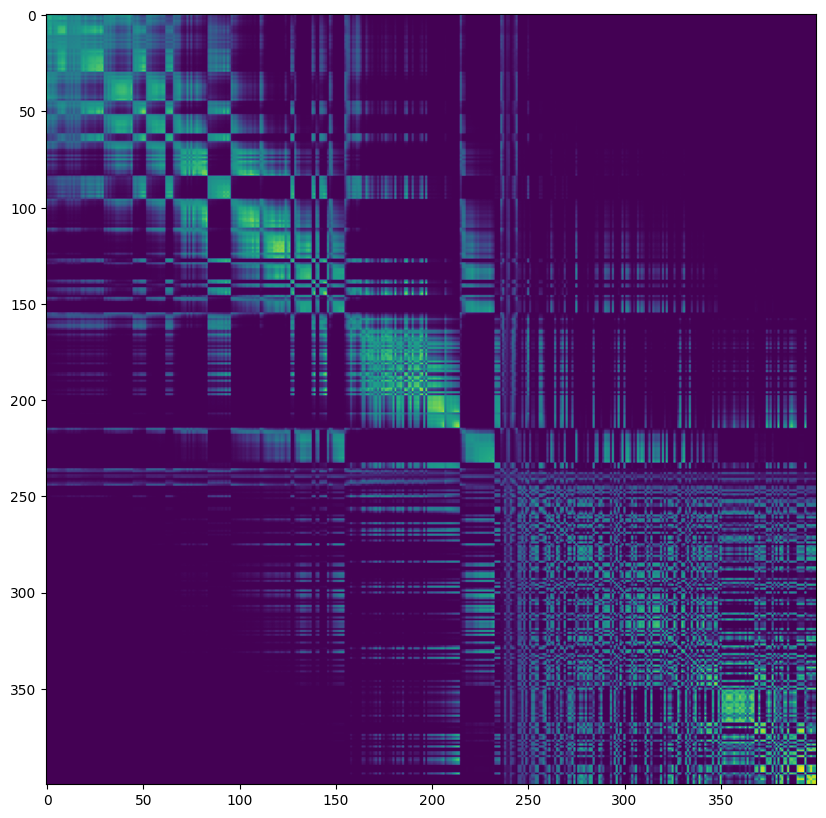

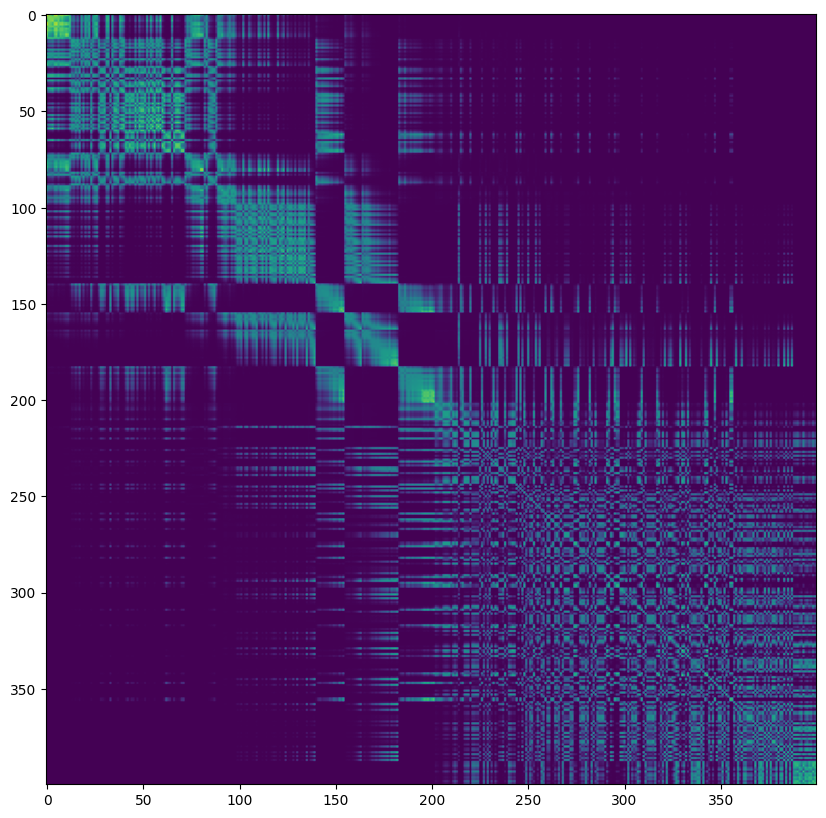

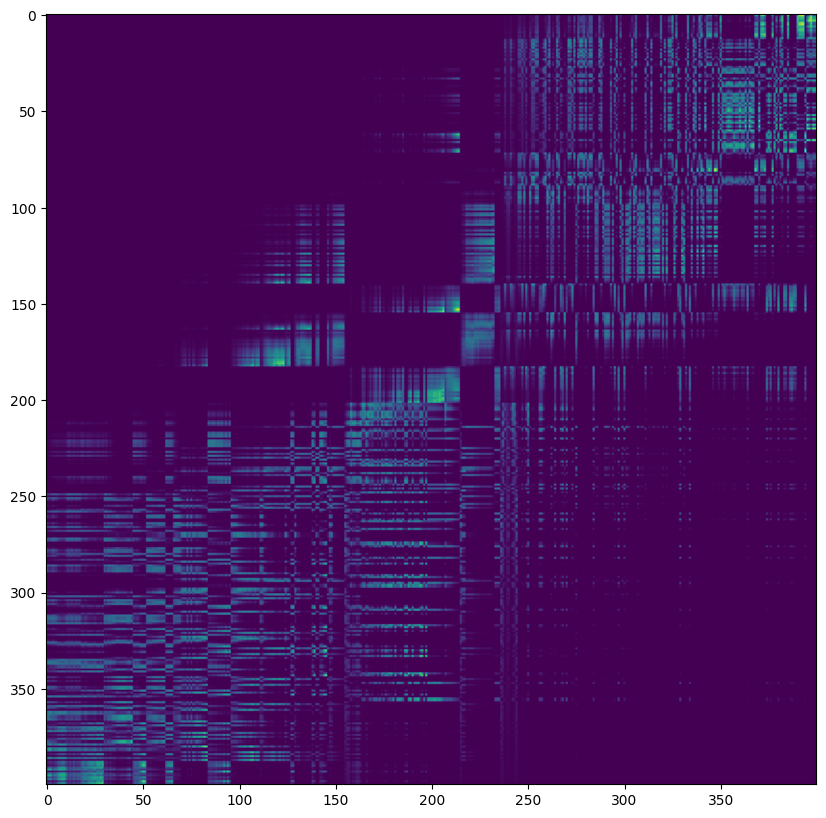

In [55]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

cut_offx=1e-10
cut_offy=1e-10
P_xx_   = P_xx*( P_xx > cut_offx)
P_xx_csr = csr_matrix(P_xx_)
perm_x = reverse_cuthill_mckee(P_xx_csr)
invp_x = invert_permutation(perm_x)

P_yy_ = P_yy*( P_yy > cut_offy)
P_yy_csr = csr_matrix(P_yy_)
perm_y = reverse_cuthill_mckee(P_yy_csr)
invp_y = invert_permutation(perm_y)

# mesh = np.meshgrid( perm_x, perm_y )
# P_ = P[mesh]
# mesh = np.meshgrid( perm_x, perm_x )
# P_xx_ = P_xx[mesh]
# mesh = np.meshgrid( perm_y, perm_y )
# P_yy_ = P_yy[mesh]

mesh_x, mesh_y = np.meshgrid( perm_x, perm_y )
P_ = P[mesh_x, mesh_y]
mesh_x, mesh_y = np.meshgrid( perm_x, perm_x )
P_xx_ = P_xx[mesh_x, mesh_y]
mesh_x, mesh_y = np.meshgrid( perm_y, perm_y )
P_yy_ = P_yy[mesh_x, mesh_y]

size=10
plt.figure( figsize=(size,size))
plt.imshow( P_xx_ );
plt.figure( figsize=(size,size))
plt.imshow( P_yy_ );
plt.figure( figsize=(size,size))
plt.imshow( P_ );

## SVD and low rank approximation

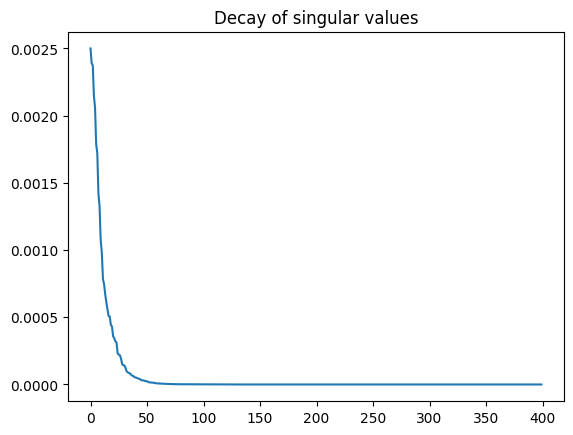

In [48]:
u,s,v = np.linalg.svd(P)

plt.figure()
plt.title("Decay of singular values")
plt.plot(s)

### Clustering from Euclidean distance ###

Shape:
(2, 400)
(400,)


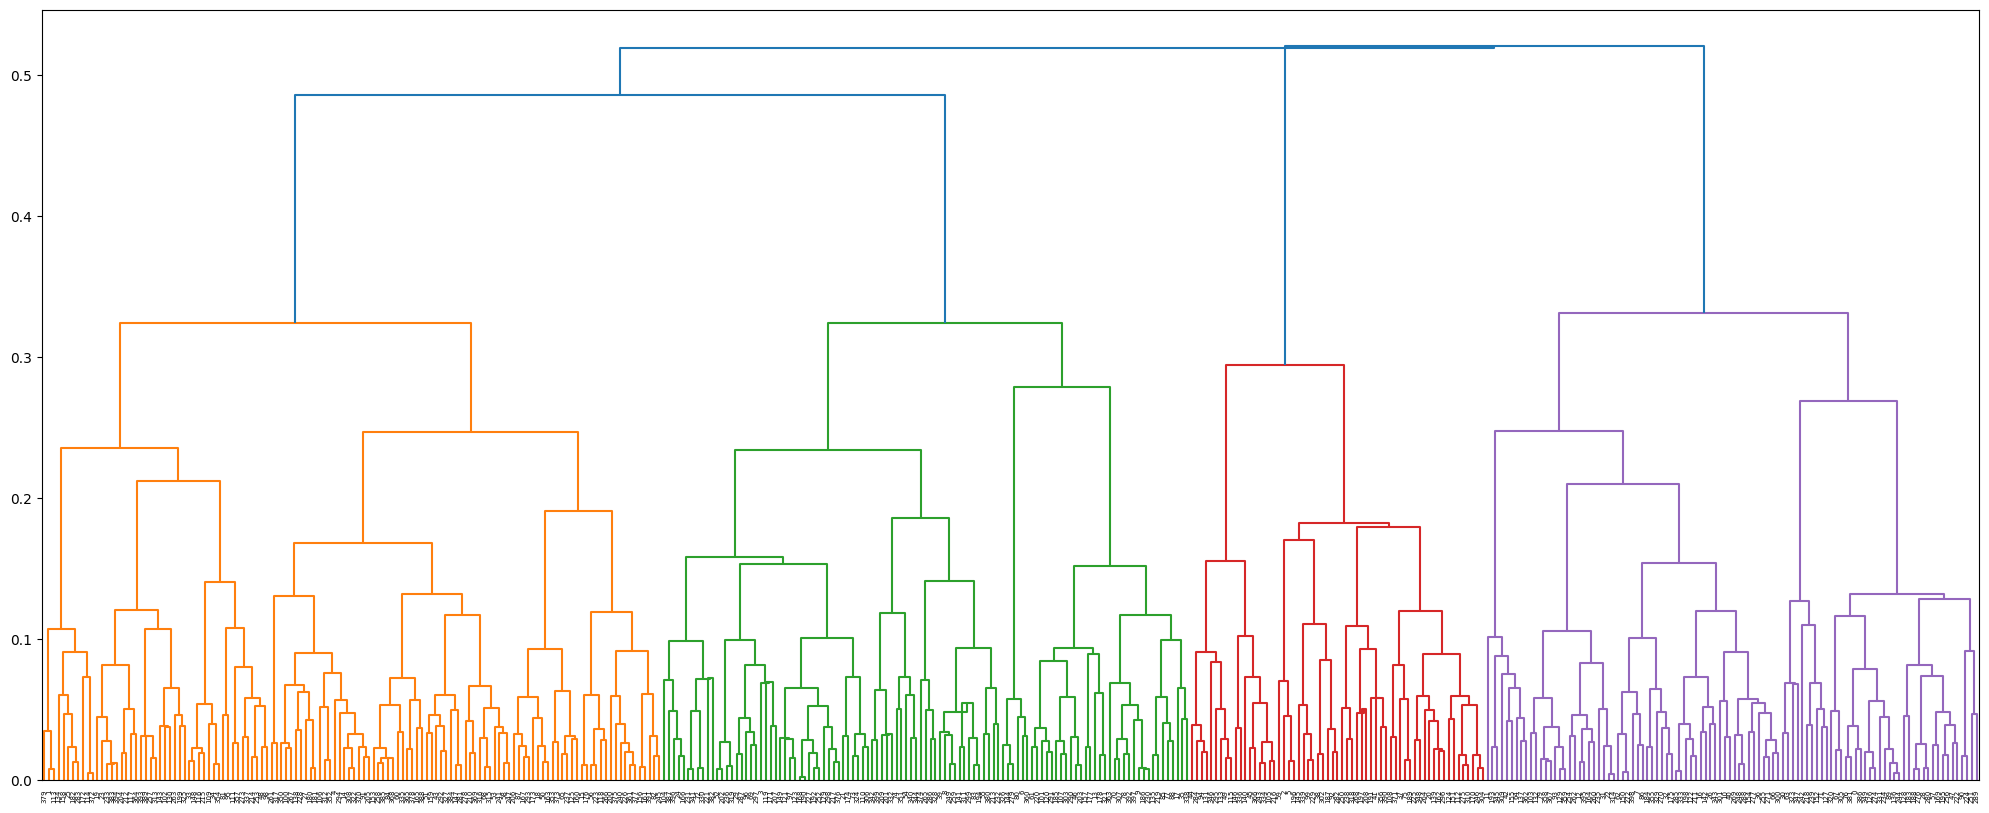

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

print("Shape:")
print(x.shape)

Z = linkage(x.T, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

W = np.array( Z, dtype=int)
#print(W)

count = x.shape[1]
clusters = [ [i] for i in range(count) ]
for merge in W:
    i,j,k,l = merge
    new_cluster = clusters[i] + clusters[j]
    clusters.append( new_cluster )
    
p1 = np.array( clusters[-1] )
print(p1.shape)

Shape:
(2, 400)
(400,)


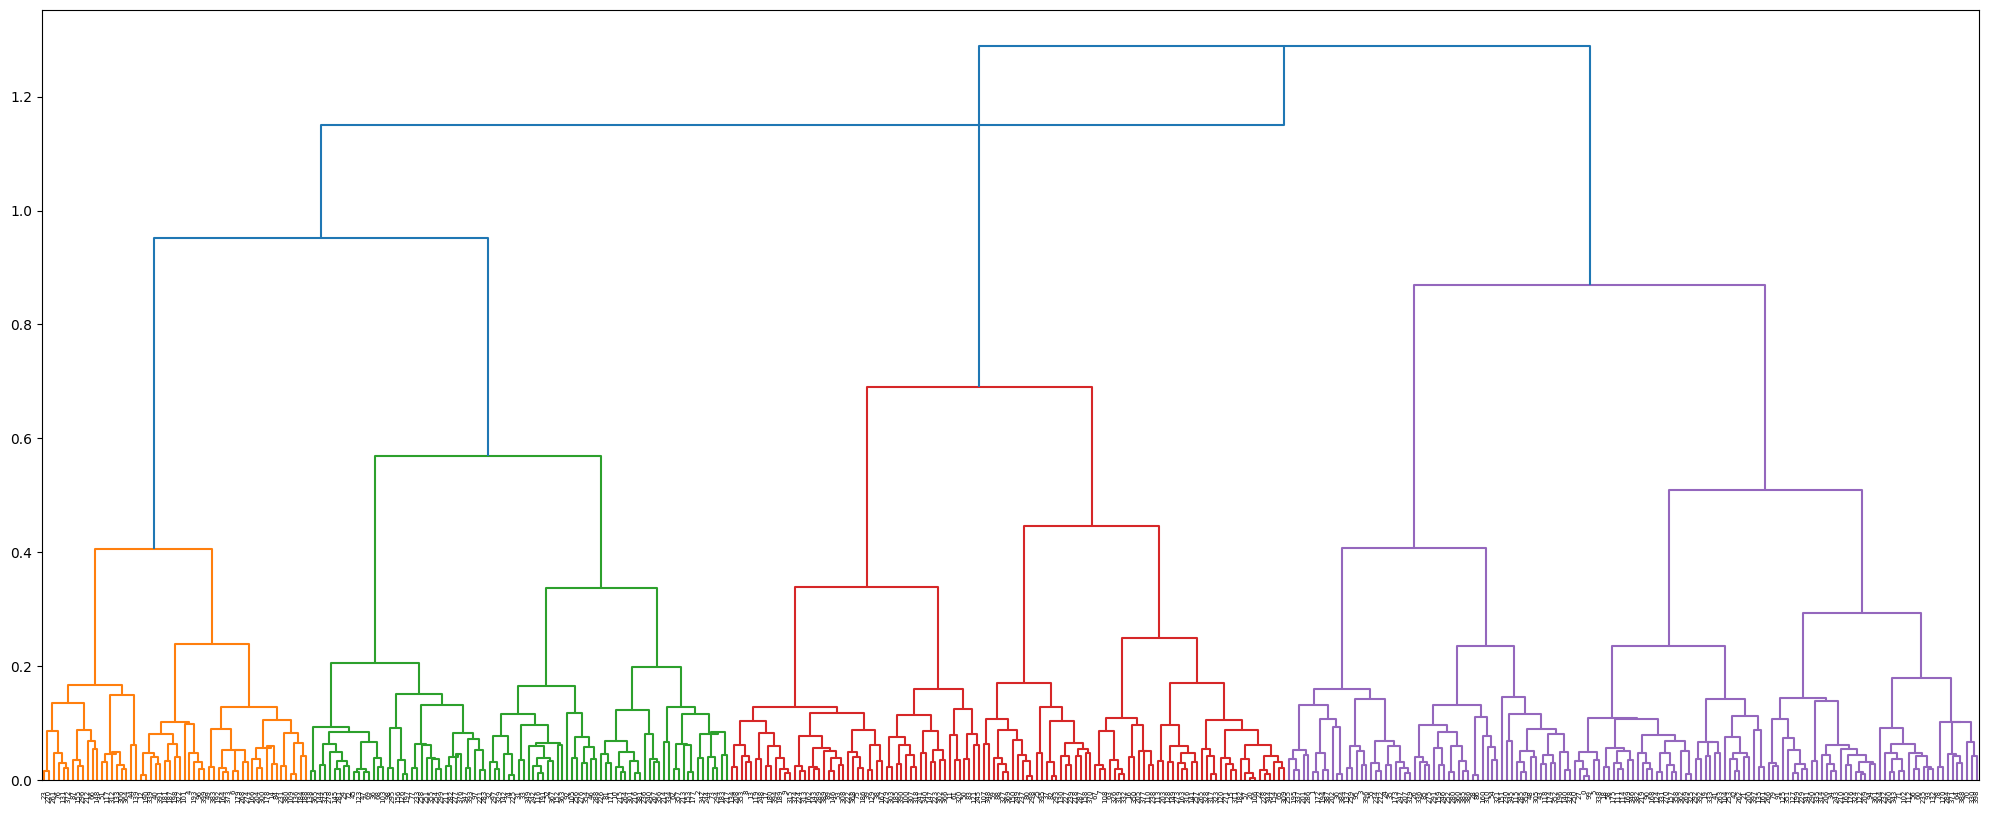

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

print("Shape:")
print(x.shape)

Z = linkage(y.T, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

W = np.array( Z, dtype=int)
#print(W)

count = x.shape[1]
clusters = [ [i] for i in range(count) ]
for merge in W:
    i,j,k,l = merge
    new_cluster = clusters[i] + clusters[j]
    clusters.append( new_cluster )
    
p2 = np.array( clusters[-1] )
print(p2.shape)

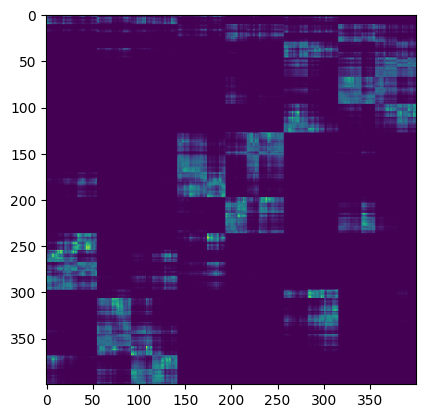

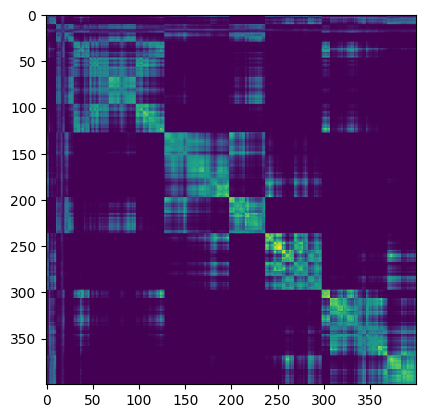

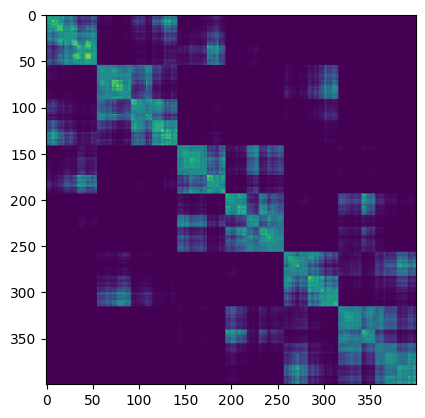

In [51]:
clustered_P = np.empty_like(P)
clustered_P[np.arange(p1.size)] = P[p1]
clustered_P = clustered_P.T
clustered_P[np.arange(p2.size)] = clustered_P[p2]
clustered_P = clustered_P.T

plt.figure()
plt.imshow(clustered_P);

clustered_P_xx = np.dot( clustered_P, clustered_P.T )
clustered_P_yy = np.dot( clustered_P.T, clustered_P )
plt.figure()
plt.imshow( clustered_P_xx );
plt.figure()
plt.imshow( clustered_P_yy );

### Clustering from the optimal transport ###

Shape:
(400, 400)
(400,)


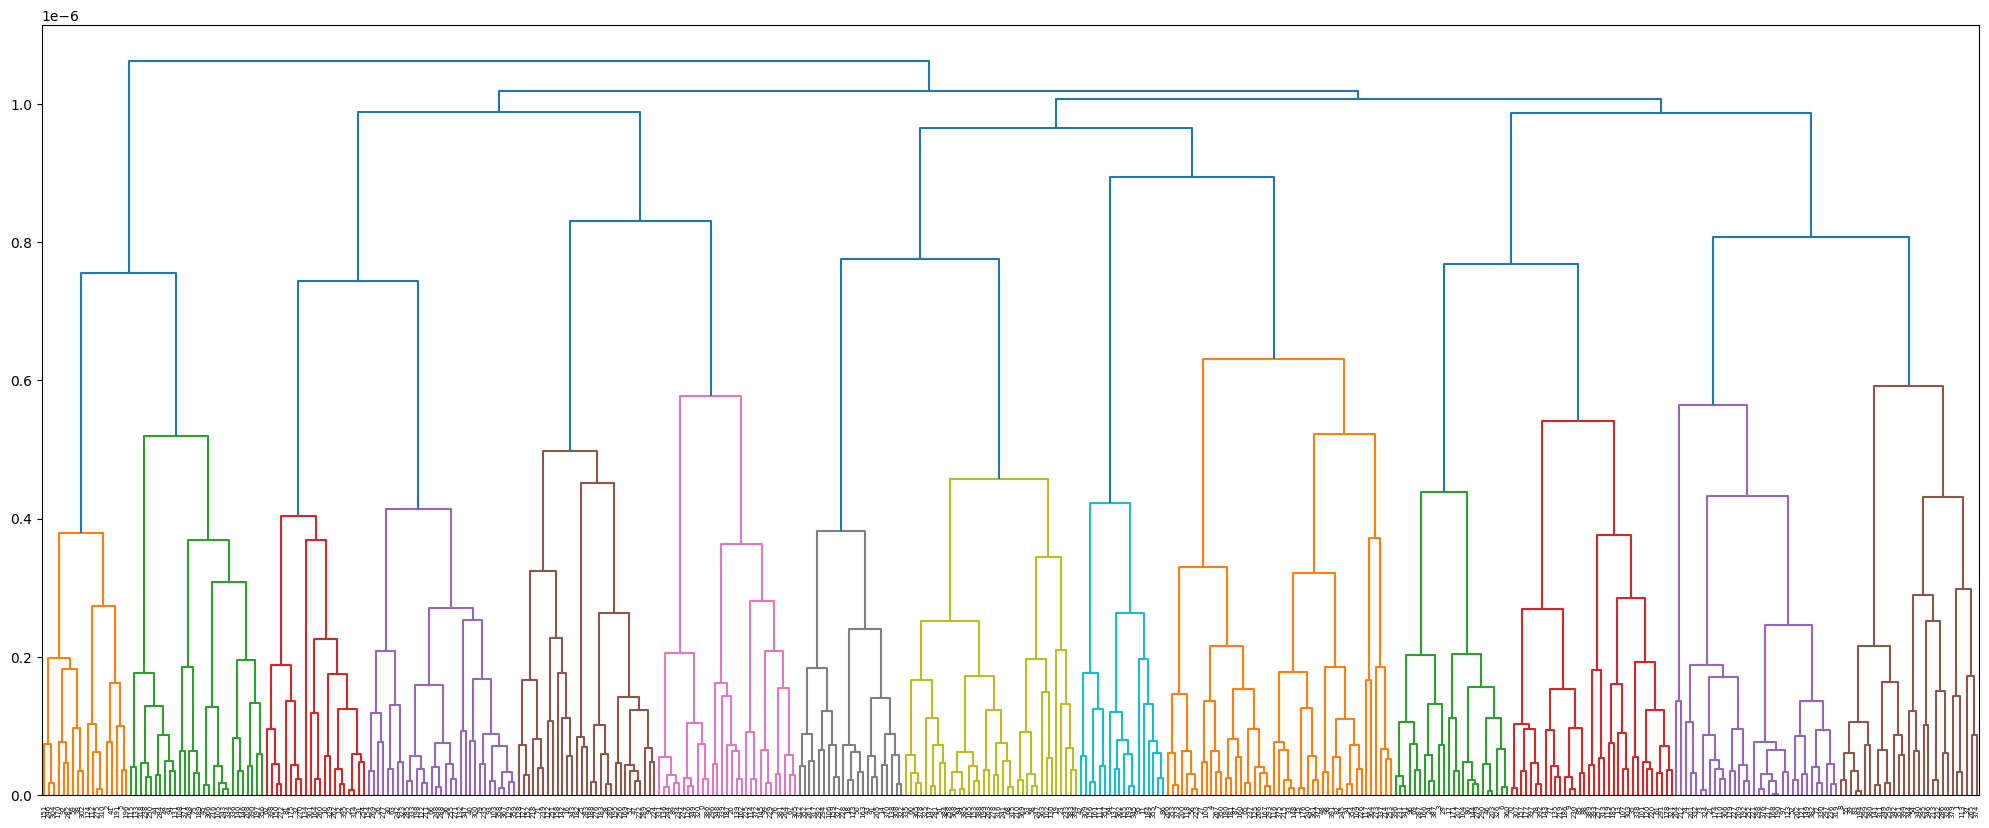

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

print("Shape:")
print( P_xx.shape)

Z = linkage(P_xx, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

W = np.array( Z, dtype=int)

count = x.shape[1]
clusters = [ [i] for i in range(count) ]
for merge in W:
    i,j,k,l = merge
    new_cluster = clusters[i] + clusters[j]
    clusters.append( new_cluster )
    
p1 = np.array( clusters[-1] )
print(p1.shape)

Shape:
(2, 400)
(400,)


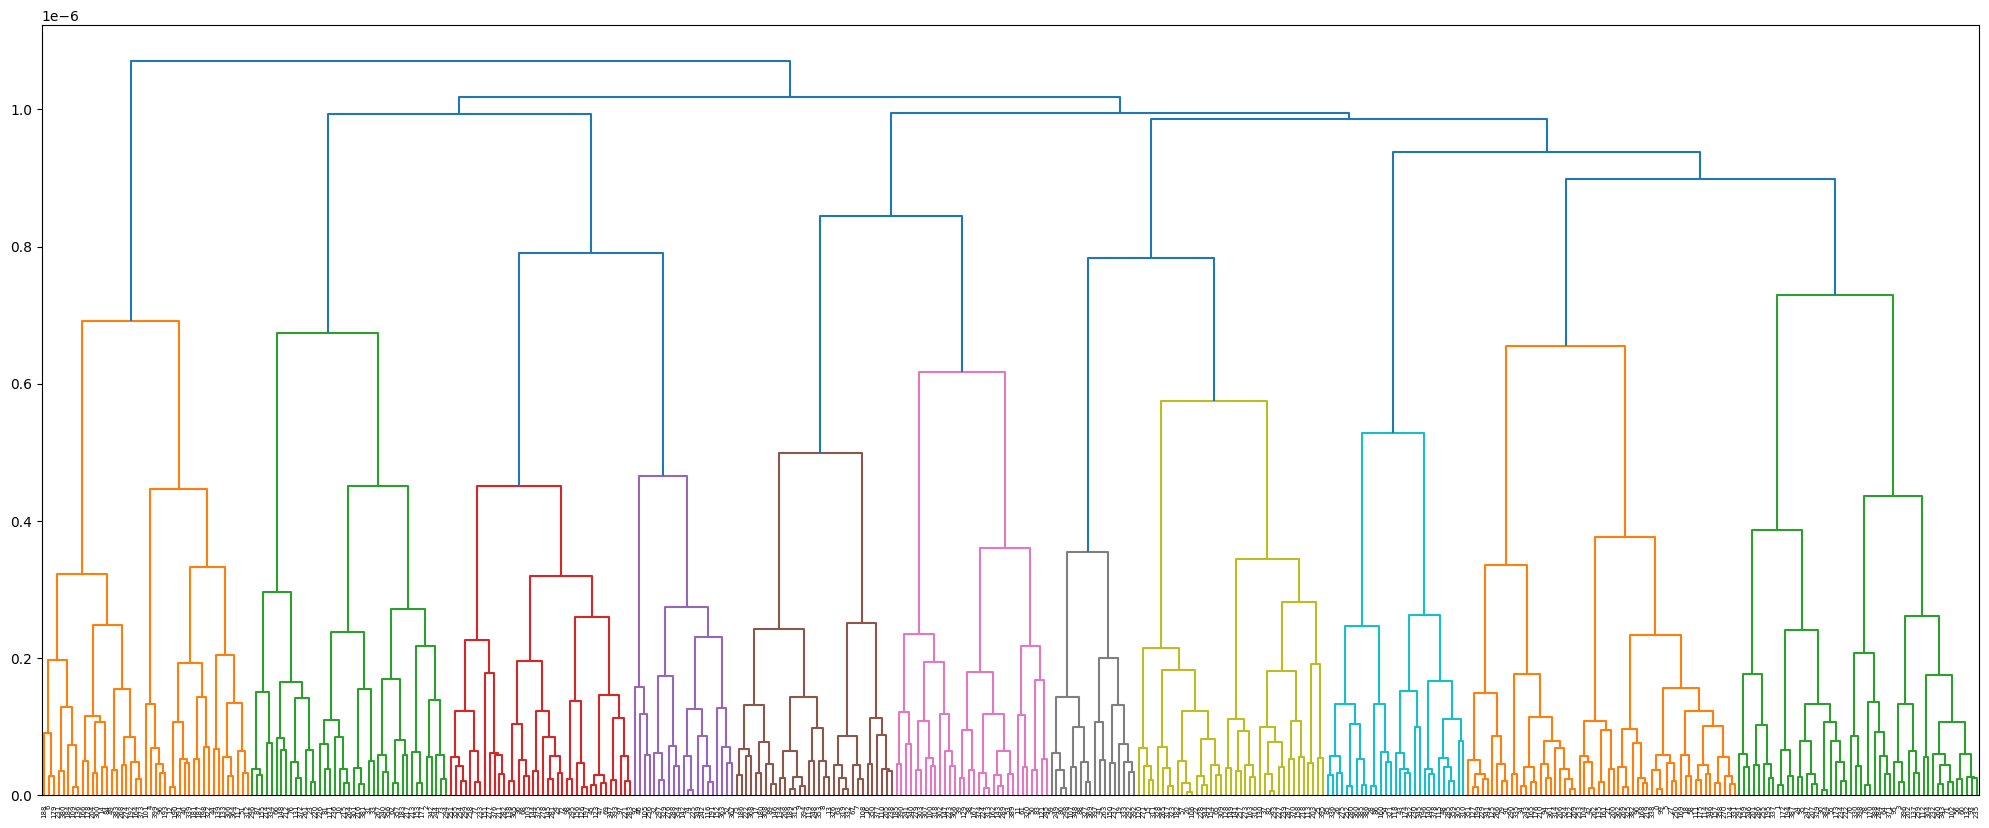

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

print("Shape:")
print(y.shape)

Z = linkage(P_yy, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

W = np.array( Z, dtype=int)
#print(W)

count = x.shape[1]
clusters = [ [i] for i in range(count) ]
for merge in W:
    i,j,k,l = merge
    new_cluster = clusters[i] + clusters[j]
    clusters.append( new_cluster )
    
p2 = np.array( clusters[-1] )
print(p2.shape)

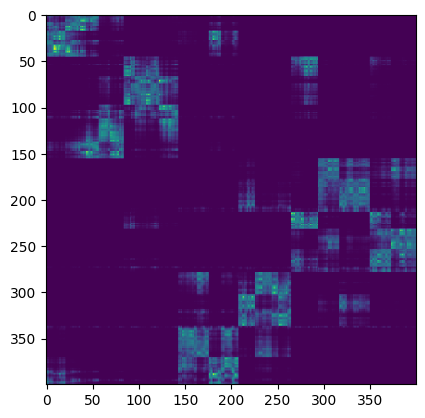

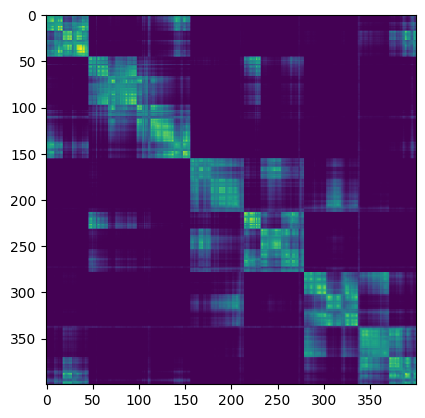

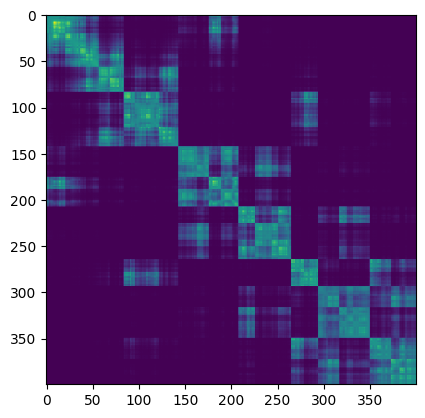

In [54]:
clustered_P = np.empty_like(P)
clustered_P[np.arange(p1.size)] = P[p1]
clustered_P = clustered_P.T
clustered_P[np.arange(p2.size)] = clustered_P[p2]
clustered_P = clustered_P.T

plt.figure()
plt.imshow(clustered_P);

clustered_P_xx = np.dot( clustered_P, clustered_P.T )
clustered_P_yy = np.dot( clustered_P.T, clustered_P )
plt.figure()
plt.imshow( clustered_P_xx );
plt.figure()
plt.imshow( clustered_P_yy );